Fitting 3 folds for each of 20 candidates, totalling 60 fits
Best Parameters: {'n_estimators': 100, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_features': 'log2', 'max_depth': 10}


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/

Mean Squared Error: 2021834.19
R-squared: 0.7008


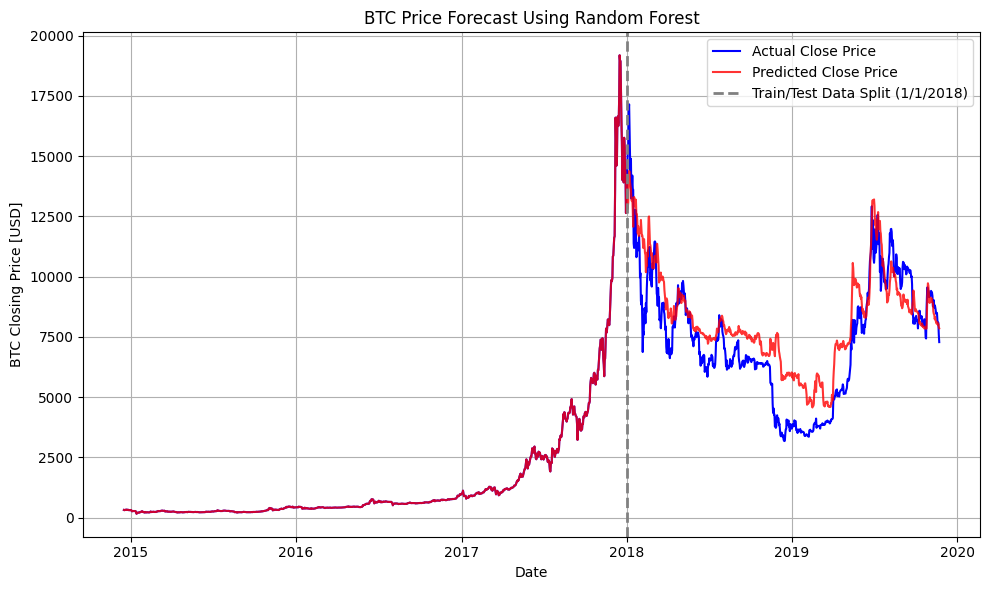

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import TimeSeriesSplit, RandomizedSearchCV

#Preparing Data
sentiments = pd.read_csv('DailySentimentSummary.csv')
price = pd.read_csv('BTC-Daily.csv')

#Standardizing Column Names and Dates
for dataset in (sentiments, price):
    dataset.columns = dataset.columns.str.strip().str.lower().str.replace(' ', '_')
    dataset['date'] = pd.to_datetime(dataset['date']).dt.date

price = price[['date', 'open', 'high', 'low', 'close', 'volume_btc', 'volume_usd']]
combined_data = pd.merge(price, sentiments, on='date', how='inner').sort_values('date').reset_index(drop=True)

#Features

#Sentiment Ratios
combined_data['positive_sent'] = combined_data['positive_tweets'] / combined_data['total_tweets']
combined_data['negative_sent'] = combined_data['negative_tweets'] / combined_data['total_tweets']
combined_data['neutral_sent']  = combined_data['neutral_tweets']  / combined_data['total_tweets']

#Lag Features
combined_data['sentiment_lag1'] = combined_data['avg_compound_score'].shift(1)
combined_data['price_lag1'] = combined_data['close'].shift(1)

#3 Day Averages
combined_data['sentiment_3d_avg'] = combined_data['avg_compound_score'].rolling(3).mean()
combined_data['price_3d_avg'] = combined_data['close'].rolling(3).mean()

#Momentum Features
combined_data['price_momentum'] = combined_data['close'] - combined_data['price_lag1']
combined_data['price_pct_change'] = combined_data['close'].pct_change()

#7 Day Volatility
combined_data['volatility_7d'] = combined_data['close'].rolling(window=7).std()

#Price and Sentiment Trend
combined_data['price_trend_up'] = (combined_data['price_lag1'] < combined_data['close']).astype(int)
combined_data['sentiment_trend_up'] = (combined_data['sentiment_lag1'] < combined_data['avg_compound_score']).astype(int)

combined_data['days_since_start'] = (pd.to_datetime(combined_data['date']) - pd.to_datetime(combined_data['date'].min())).dt.days

#Technical Indicators
#Commonly used for financial data

#Moving Average Convergence Divergence
ema12 = combined_data['close'].ewm(span=12, adjust=False).mean()
ema26 = combined_data['close'].ewm(span=26, adjust=False).mean()
combined_data['macd'] = ema12 - ema26

#Relative Strength Index (14 day)
delta = combined_data['close'].diff()
gain = delta.clip(lower=0)
loss = -delta.clip(upper=0)
average_gain = gain.rolling(window=14).mean()
average_loss = loss.rolling(window=14).mean()
rs = average_gain / average_loss
combined_data['rsi14'] = 100 - (100 / (1 + rs))

#Bollinger Bandwidth
mb = combined_data['close'].rolling(20).mean()
sd20 = combined_data['close'].rolling(20).std()
combined_data['boll_bandwidth'] = (mb + 2 * sd20 - (mb - 2 * sd20)) / mb

#Average True Range (14 day)
tr1 = combined_data['high'] - combined_data['low']
tr2 = (combined_data['high'] - combined_data['close'].shift(1)).abs()
tr3 = (combined_data['low'] - combined_data['close'].shift(1)).abs()
tr = pd.concat([tr1, tr2, tr3], axis=1).max(axis=1)
combined_data['atr14'] = tr.rolling(window=14).mean()

#On-Balance Volume
direction = np.sign(combined_data['close'].diff()).fillna(0)
combined_data['obv'] = (direction * combined_data['volume_btc']).cumsum()

#Set Tomorrow's Closing Price as Target Variable
combined_data['target'] = combined_data['close'].shift(-1)
combined_data.dropna(inplace=True)
combined_data.reset_index(drop=True, inplace=True)

#Splitting Data into Train/Test at 2018 Line
split_date = pd.to_datetime('2018-01-01').date()
train_data = combined_data[combined_data['date'] < split_date]
test_data = combined_data[combined_data['date'] >= split_date]

#Set Features
features = ['price_lag1', 'avg_compound_score', 'positive_sent', 'negative_sent', 'neutral_sent', 'sentiment_lag1', 'sentiment_3d_avg', 'price_3d_avg', 'price_momentum', 'price_pct_change', 'volatility_7d', 'price_trend_up', 'sentiment_trend_up', 'days_since_start', 'macd', 'rsi14', 'boll_bandwidth', 'atr14', 'obv']

#Model Inputs
X_train = train_data[features]
y_train = train_data['target']
X_test  = test_data[features]
y_test  = test_data['target']

#Hyperparameter Tuning Using RandomizedSearchCV
param_grid = {
    'n_estimators': [100, 200, 300, 500],
    'max_depth': [5, 10, 15, 20, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2']
}

tscv = TimeSeriesSplit(n_splits=3)
param_search = RandomizedSearchCV(RandomForestRegressor(random_state=42, n_jobs=-1), param_distributions=param_grid, n_iter=20, cv=tscv, scoring='r2', verbose=1, n_jobs=-1, random_state=42)
param_search.fit(X_train, y_train)
model = param_search.best_estimator_
print("Best Parameters:", param_search.best_params_)

#Making Predictions
#Predicts tomorrow's closing price using Twitter Sentiment and previous prediction
predictions = []
last_row = train_data.iloc[-1].copy()

for _, row in test_data.iterrows():
    feature_vector = [
        last_row['close'],
        row['avg_compound_score'],
        row['positive_sent'], row['negative_sent'], row['neutral_sent'],
        last_row['avg_compound_score'],
        row['avg_compound_score'],
        last_row['price_3d_avg'],
        last_row['price_momentum'],
        last_row['price_pct_change'],
        row['volatility_7d'],
        int(last_row['price_trend_up']),
        int(last_row['sentiment_trend_up']),
        row['days_since_start'],
        row['macd'], row['rsi14'], row['boll_bandwidth'],
        row['atr14'], row['obv']
    ]
    pred = model.predict([feature_vector])[0]
    predictions.append(pred)
    last_row = row.copy()
    last_row['close'] = pred

#Analysis Values and Plot
mse = mean_squared_error(y_test, predictions)
r2 = r2_score(y_test, predictions)
print(f'Mean Squared Error: {mse:.2f}')
print(f'R-squared: {r2:.4f}')

pred_full = list(combined_data.loc[combined_data['date'] < split_date, 'close']) + predictions
full_dates = list(combined_data.loc[combined_data['date'] < split_date, 'date']) + list(test_data['date'])

plt.figure(figsize=(10, 6))
plt.plot(combined_data['date'], combined_data['close'], label='Actual Close Price', color='blue')
plt.plot(full_dates, pred_full, label='Predicted Close Price', color='red', alpha=0.8)
plt.axvline(x=split_date, color='gray', linestyle='--', linewidth=2, label='Train/Test Data Split (1/1/2018)')
plt.xlabel('Date')
plt.ylabel('BTC Closing Price [USD]')
plt.title('BTC Price Forecast Using Random Forest')
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()